FilFinder Tutorial
==================

This tutorial demonstrates the FilFinder algorithm on a simulated data set. The updated algorithm from ```FilFinder2D``` is used here, which is valid for versions >1.5. This tutorial was tested with python 3.6.

The example data is included in the github repository [here](https://github.com/e-koch/FilFinder/blob/master/examples/filaments_updatedhdr.fits).

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u

# Optional settings for the plots. Comment out if needed.
import seaborn as sb
sb.set_context('poster')

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12., 9.6)

Input Data
--------

There are two caveats to the input data:

1) All angular and physical conversions assume that pixels in the image can be treated as squares. `FilFinder2D` is not aware of any axis misalignments! If you're data does not have aligned celestial axes, we recommend reprojecting the data onto a square grid.

2) The beam size is characterized by the major axis, assuming a 2D Gaussian beam shape. If the beam size of your data is highly elliptical, it is recommended to convolve the data to a circular beam.

```FilFinder2D``` accepts several input types, including a FITS HDU and numpy arrays.

In [121]:
from fil_finder import FilFinder2D
from astropy.io import fits

hdu = fits.open("../examples/filaments_updatedhdr.fits")[0]

fil = FilFinder2D(hdu)

In [122]:
# HDU data as an array
arr = hdu.data
hdr = hdu.header

fil = FilFinder2D(arr)

/home/eric/Dropbox/code_development/filaments/build/lib.linux-x86_64-3.6/fil_finder/filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")


In this case, no WCS information is given and all results will be returned in pixel units. Angular units can be returned when the header is specified:

In [123]:
fil = FilFinder2D(arr, header=hdr)

If [spectral-cube](https://spectral-cube.readthedocs.io/en/latest/) is installed, the `Projection` or `Slice` classes can also be passed to `FilFinder2D`:

In [124]:
from spectral_cube import Projection

proj = Projection.from_hdu(hdu)

fil = FilFinder2D(proj)

Other Inputs to `FilFinder2D`:
----------------------------

Note that numerical inputs must be given as `~astropy.units.Quantity` object with the appropriate unit.

**Distance** -- To facilitate conversions to physical units, a distance can be given to `FilFinder2D`:

In [125]:
fil = FilFinder2D(hdu, distance=250 * u.pc)

**Angular Scale** -- If no header information is given, the pixel-to-angular conversion can be given:

In [126]:
fil = FilFinder2D(arr, ang_scale=0.1 * u.deg)

/home/eric/Dropbox/code_development/filaments/build/lib.linux-x86_64-3.6/fil_finder/base_conversions.py:55: UserWarning: Cannot find 'BMAJ' in the header. Try installing the `radio_beam` package for loading header information.
  warn("Cannot find 'BMAJ' in the header. Try installing"
/home/eric/Dropbox/code_development/filaments/build/lib.linux-x86_64-3.6/fil_finder/base_conversions.py:63: UserWarning: Cannot find 'BMIN' in the header. Assuming circular beam.
  warn("Cannot find 'BMIN' in the header. Assuming circular beam.")
/home/eric/Dropbox/code_development/filaments/build/lib.linux-x86_64-3.6/fil_finder/base_conversions.py:69: UserWarning: Cannot find 'BPA' in the header. Assuming PA of 0.
  warn("Cannot find 'BPA' in the header. Assuming PA of 0.")
/home/eric/Dropbox/code_development/filaments/build/lib.linux-x86_64-3.6/fil_finder/filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")


**Beamwidth** -- If the major axis of the beam is contained in the header, it will be automatically read in. If that information is not in the header, the beam size can be passed separately:

In [127]:
fil = FilFinder2D(hdu, beamwidth=10 * u.arcsec)

**Custom Filament Masks** -- If you have a pre-computed filament mask, the mask array can be passed:

In [128]:
# Example custom mask
mask = hdu.data > 1.

fil = FilFinder2D(hdu, mask=mask)

The custom mask must have the same shape as the inputed image.

**Save Name** -- A prefix for saved plots and table can be given:

In [129]:
fil = FilFinder2D(hdu, save_name="FilFinder_Output")

For the purposes of this tutorial, we will assume that the data has WCS information and a well-defined distance:

In [130]:
fil = FilFinder2D(hdu, distance=260 * u.pc)

The beamwidth is $24''$ and is defined in the header.

Image Preprocessing
-----------------

Prior to creating the mask, it can be helpful to first *flatten* the image of bright compact sources. `FilFinder2D` uses an arctan transform, where the data are first normalized by some percentile value of the data:

In [131]:
fil.preprocess_image(flatten_percent=95)

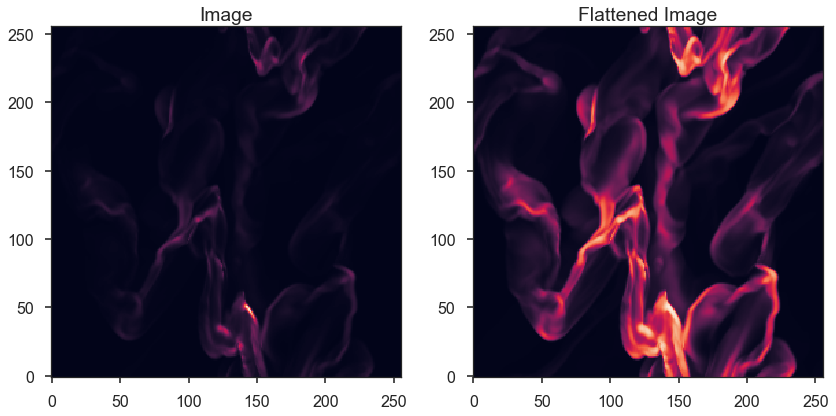

In [132]:
plt.subplot(121)
plt.imshow(fil.image.value, origin='lower')
plt.title("Image")
plt.subplot(122)
plt.imshow(fil.flat_img.value, origin='lower')
plt.title("Flattened Image")
plt.tight_layout()

If a percentile is not given, `FilFinder2D.preprocess_image` will try to fit a log-normal distribution to the data and will set the threshold at $\mu + 2 \sigma$. **There are no checks for the quality of the fit. Use only if you are confident that the brightness distribution is close to a log-normal.**

If you wish to run the masking procedure without flattening the image, use the command:

In [133]:
fil.preprocess_image(skip_flatten=True)

The original image will be set as `fil.flat_img` and used in the masking step.

For this example, we will use the prior flattened image.

In [134]:
fil.preprocess_image(flatten_percent=95)

Masking
--------

Creating the filament mask is a complex process performed by `FilFinder2D.create_mask`. There are several parameters that set the masking behaviour.

If a FITS header and distance were provided at the beginning, `FilFinder2D` will use default guesses based on typical filament sizes from Herschel studies of the Gould Belt clouds (e.g., [Koch & Rosolowsky 2015](https://ui.adsabs.harvard.edu/#abs/2015MNRAS.452.3435K/abstract)). These choices will not be the optimal settings in general, and we recommend trying different different parameter setting before using the resulting mask for the analysis.

If a distance was not provided, these parameters must be set. `FilFinder2D` will raise errors until the required parameters are given.

This simulated data set is an example where the default `FilFinder2D` settings do not provide an ideal filament mask:

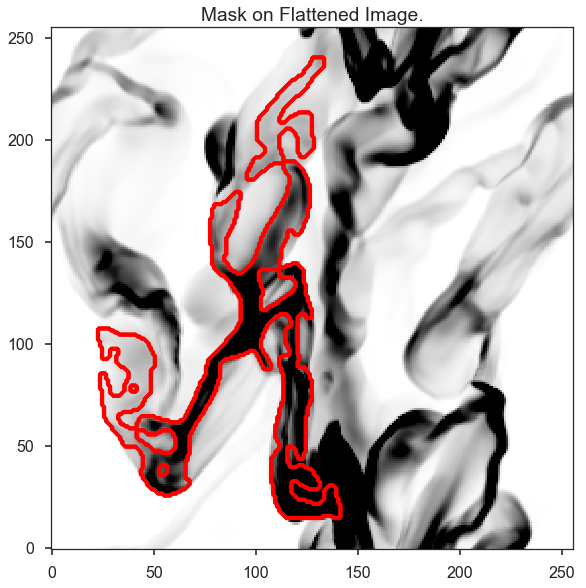

In [135]:
fil.create_mask(verbose=True)

Most of the filamentary structure has been ignored by the mask. There are several parameters that can be set to improve the mask:

* `glob_thresh` -- Set a minimum intensity for a pixel to be included in the mask. This is useful for removing noisy regions in the data from the mask. Must have the same units as `fil.image`.
* `adapt_thresh` -- The width of the element used for the adaptive thresholding mask. This is primarily the step that picks out the filamentary structure. The element size should be similar to the width of the expected filamentary structure. The default here, when distance is provided, is 0.1 pc.
* `smooth_size` -- It is often helpful to smooth the data before calculating the mask. By smoothing in small scales, small noise variations are removed resulting in a simpler skeleton structure. The default is set to 0.05 pc.
* `size_thresh` -- The minimum number of pixels a region of the mask must have to be considered real. The default is set by assuming a minimum filament size to be an ellipse with a 0.1 pc width and length of 0.5 pc. *Most data sets will require this parameter to be manually set,* as is used below.
* `regrid` -- If the pixel width of `adapt_thresh` is less than 40 pixels, the resulting mask may be fragmented due to pixelization. To increase the size of `adapt_thresh`, `regrid` interpolates the data onto a larger grid, calculates the mask on the larger grid, then interpolates the mask at the original image size.
* `border_masking` -- Observational maps may not fill the entire image, and the edges of the mapped regions tend to be noisier. `border_masking` finds regions of `NaNs` along the edge of the map and tries to remove noisy regions near the edges. Its behaviour can be controlled using `border_kwargs`, where the size of a NaN region (`size`), size of the filter used to define noisy edges (`filt_width`), and the number of times to apply that filter (`eros_iter`) can be controlled.
* `fill_hole_size` -- If there are holes within a skeleton, `fill_hole_size` can be used to fill in holes smaller than the given size.
* `use_existing_mask` -- If you gave a user-defined mask when calling `FilFinder2D`, enable this parameter to skip making a new mask.

Varying a few of these parameters will produce a much improved mask. First, since the data go right to the edges of the image, we can disable `border_masking`:

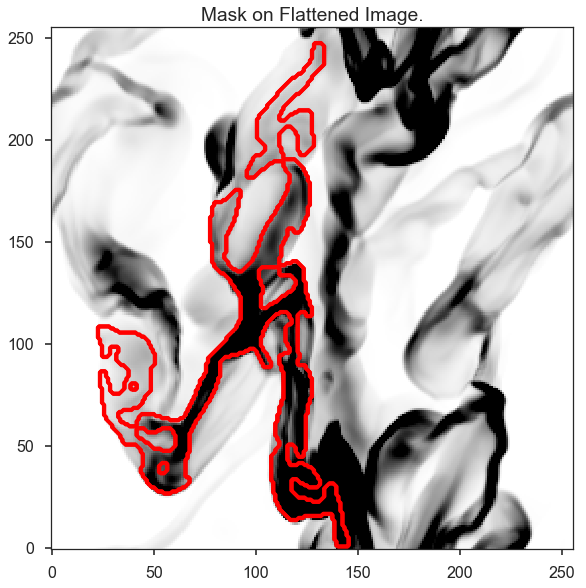

In [136]:
fil.create_mask(verbose=True, border_masking=False)

The mask now extends right to the edge of the data. However, only one structure was retained. This occurs because `size_thresh` is too large. We can manually set the value in pixel units. The size must have units of area:

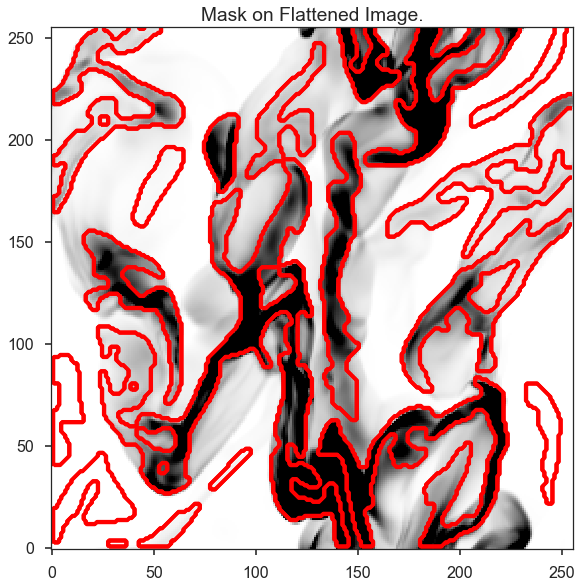

In [137]:
fil.create_mask(verbose=True, border_masking=False, size_thresh=400 * u.pix**2)

Much better! Most of the filamentary structure is now being included in the mask.

This simulated image does not have noise added in, however, most data sets will. The cell below demonstrates how to set `glob_thresh` to avoid noisy regions:

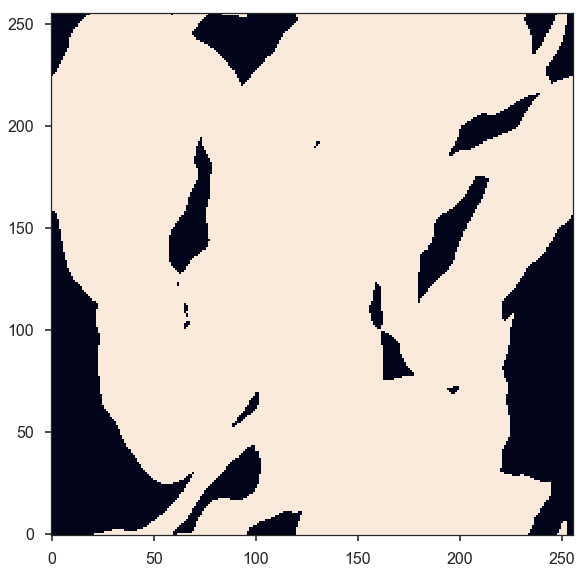

In [138]:
# Define the noise value. As a demonstration, say values below the 20th percentile here are dominated by noise
noise_level = np.percentile(fil.image, 20)
noise_level

plt.imshow(fil.image.value > noise_level, origin='lower')

The dark regions will be excluded from the final mask. The filament mask with the threshold is then:

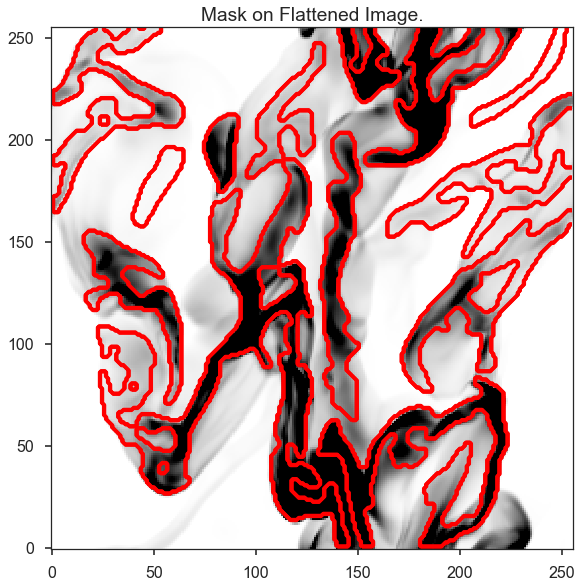

In [139]:
fil.create_mask(verbose=True, border_masking=False, size_thresh=400 * u.pix**2, glob_thresh=0.0267)

A few small region have been removed compared to the previous mask, but the structure is largely unchanged in this case.

This is a usable mask for the filament analysis.  The effects of altering the other parameters are shown in [Koch & Rosolowsky 2015](https://ui.adsabs.harvard.edu/#abs/2015MNRAS.452.3435K/abstract).

Try varying each parameter to assess its affect on your data.


If you gave a user-defined mask at the beginning, run:

In [140]:
fil.create_mask(use_existing_mask=True)

/home/eric/Dropbox/code_development/filaments/build/lib.linux-x86_64-3.6/fil_finder/filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


Skeletonization
-----------------

The next step is to reduce the mask into single-pixel-width skeleton objects. These skeletons will define the location of a filament and its path.

In `FilFinder2D`, the [medial axis](http://scikit-image.org/docs/0.10.x/auto_examples/plot_medial_transform.html) is defined to be the skeleton:

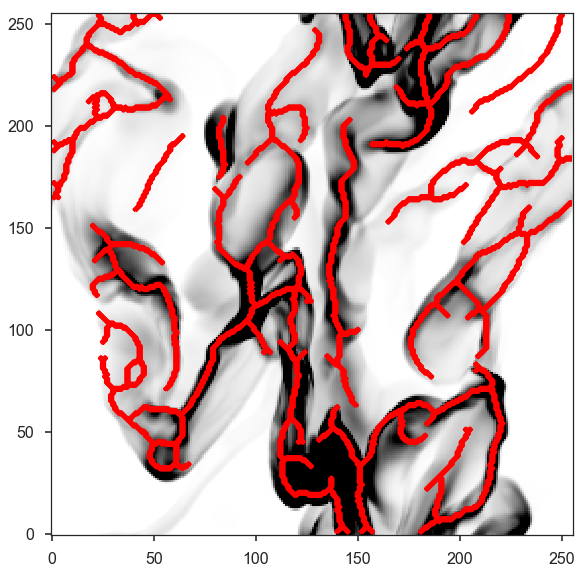

In [141]:
fil.medskel(verbose=True)

Skeletons: Pruning & Length
-------------------------------

We are now prepared to analyze the filaments. The first analysis step includes two parts: pruning the skeleton structures and finding the filament lengths. The first part removes small/unimportant spurs on the skeletons. To ensure important portions of the skeleton are retained, however, both parts are performed together.

Each skeleton is converted into a graph object using the [networkx](https://networkx.github.io/) package. We use the graph to find the longest path through the skeleton, which is used to define the structure's length. All branches in the skeleton away from this longest path are eligible to be pruned off.

This process is handled by the `FilFinder2D.analyze_skeletons` function. When using `verbose=True`, a ton of plots will get returned. To save you some scrolling, the verbose mode is highlighted for just one filament below.

With just the default settings:

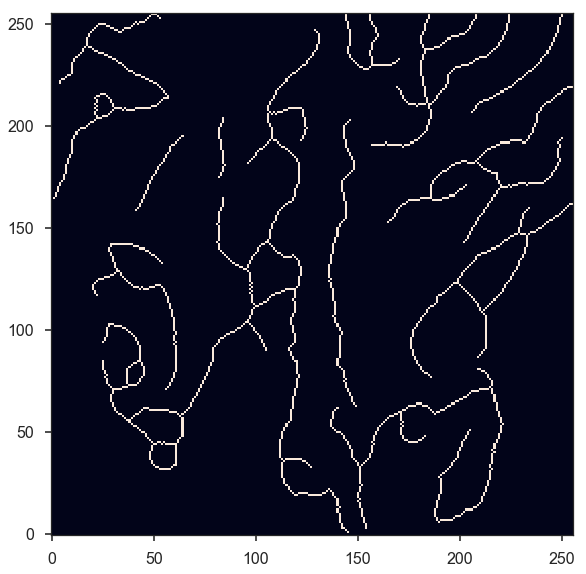

In [142]:
fil.analyze_skeletons()

plt.imshow(fil.skeleton, origin='lower')

The skeletons are largely the same, with only short branches removed.

The default settings use minimum skeleton and branch lengths based off of the beam size. To be kept, a branch must be at least three times the length of the beam and a skeleton must have a length of 5 times the beam. Practically, this will only remove very small features.

These parameters, and ones related to the pruning, can be manually set:

* `prune_criteria` -- The criteria for removing a branch can be altered. The default ('all') uses a mix of the average intensity along the branch and its length. The length alone can be used for pruning with `prune_criteria='length'`. All branches below this length will be removed. Finally, only the intensity can be used for pruning (`prune_criteria='intensity'`). A branch is kept in this case by comparing the average intensity along the branch to the average over the whole filament. The critical fraction that determines whether a branch is important is set by `relintens_thresh`.
* `relintens_thresh` -- Set the critical intensity comparison for intensity-based pruning.
* `nbeam_lengths` -- Number of beam widths a skeleton must have to be considered a valid structure. Default is 5.
* `branch_nbeam_lengths` -- Number of beam widths a branch must have to avoid pruning. Default is 3.
* `skel_thresh` -- Minimum length for a skeleton. Overrides `nbeam_lengths`. Must have a unit of length.
* `branch_thresh` -- Minimum length for a branch. Overrides `branch_nbeam_lengths`. Must have a unit of length.
* `max_prune_iter` -- Number of pruning iterations. The default is 10, which works well for multiple data sets used in the testing process. A warning is returned if the maximum is reached. **New in `FilFinder2D`!**

Here we will highlight the effect of pruning away moderately long branches. Note that re-running `FilFinder2D.analyze_skeletons` will start on the *output* from the previous call, not that original skeleton from `FilFinder2D.medskel`.

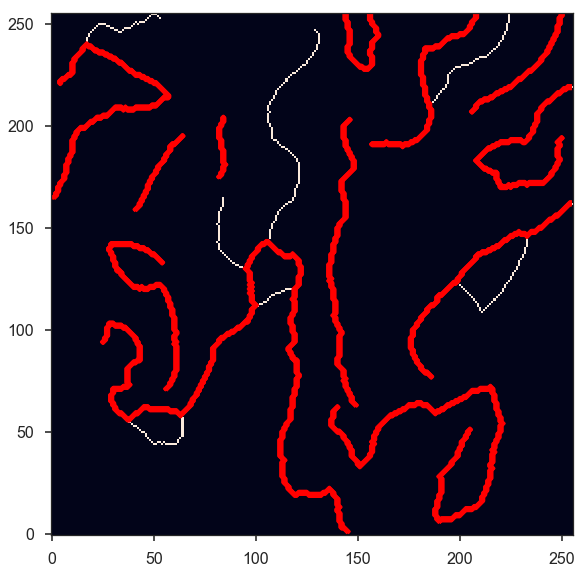

In [143]:
fil.analyze_skeletons(branch_thresh=40 * u.pix, prune_criteria='length')

plt.imshow(fil.skeleton, origin='lower')
plt.contour(fil.skeleton_longpath, colors='r')

The structure have now been significantly pruned. The red contours highlight the longest paths through each skeleton.

If we continue to increase the branch threshold, the skeletons will converge to the longest path structures:

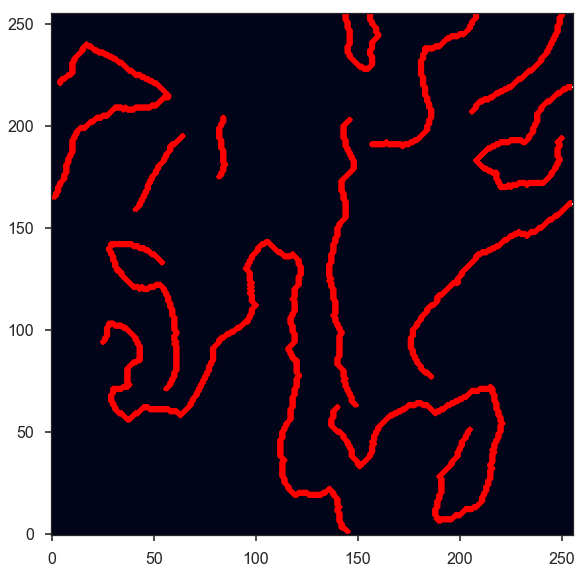

In [144]:
fil.analyze_skeletons(branch_thresh=400 * u.pix, prune_criteria='length')

plt.imshow(fil.skeleton, origin='lower')
plt.contour(fil.skeleton_longpath, colors='r')

This is an extreme case of pruning and a significant amount of real structure was removed. We will return to a less pruned version to use for the rest of the tutorial:

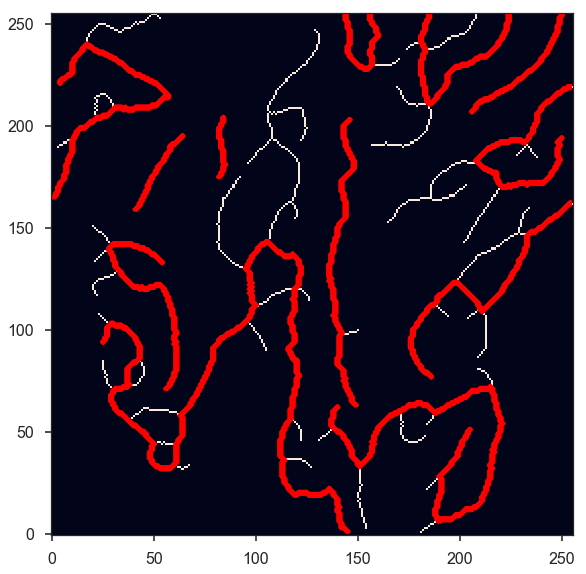

In [145]:
fil.medskel(verbose=False)
fil.analyze_skeletons(branch_thresh=5 * u.pix, prune_criteria='length')

plt.imshow(fil.skeleton, origin='lower')
plt.contour(fil.skeleton_longpath, colors='r')

Another new feature of `FilFinder2D` is that each filament has its own analysis class defined in `fil.filaments`:

In [146]:
fil.filaments

This allows for each skeleton to be analyzed independently, in case your analysis requires fine-tuning.

A separate tutorial on the `Filament2D` class is available from the [docs page](http://fil-finder.readthedocs.io/en/latest/). We will highlight some of the features here to show the plotting outputs. Each `Filament2D` class does not contain that entire image, however, to avoid making multiple copies of the data.

The first filament is quite large with a lot of structure. We can plot the output from `FilFinder2D.analyze_skeletons` for just one filament with:

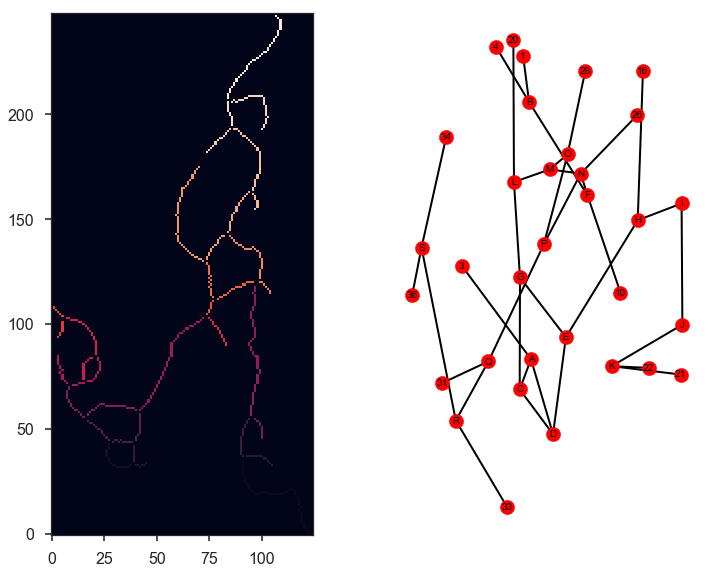

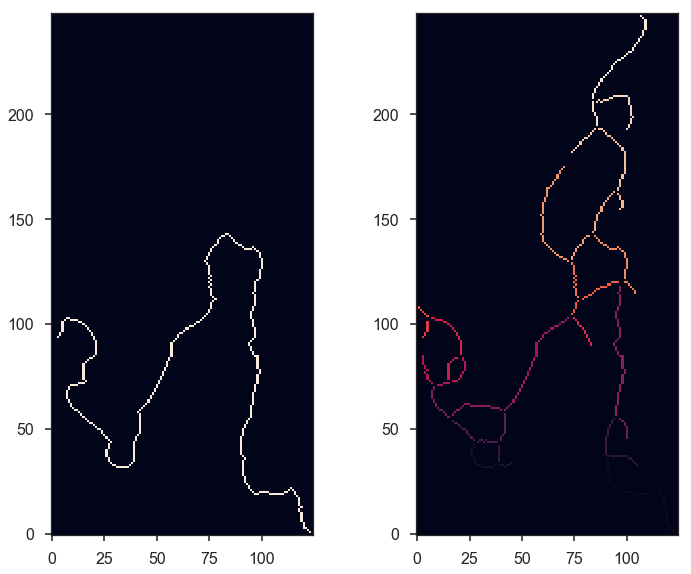

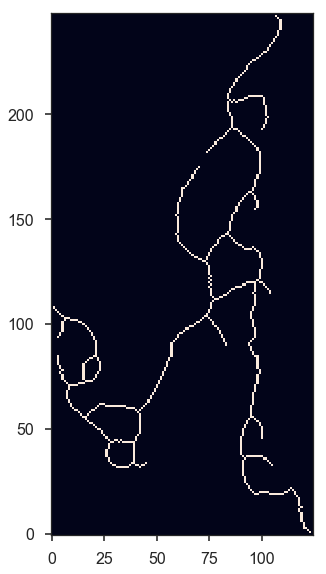

In [147]:
fil1 = fil.filaments[0]
fil1.skeleton_analysis(fil.image, verbose=True, branch_thresh=5 * u.pix, prune_criteria='length')

Three plots are returned:

* The labeled branch array (left) with intersection points removed and the equivalent graph structure (right).
* The longest path through the skeleton (left) and the same labeled branch array (right) as above.
* The final, pruned skeleton structure.

Only one set of plots is shown after the iterative pruning has been finished.

The lengths of the filament's longest paths are now calculated:

In [148]:
fil.lengths()

<Quantity [453.75945135, 270.73506474, 159.46803743, 127.63961031,
           156.30865787, 138.61017306,  46.11269837, 165.75230868,
            32.3137085 , 115.56854249,  72.08326112,  65.69848481] pix>

The default output is in pixel units, but if the angular and physical scales are defined, they can be converted into other units:

In [149]:
fil.lengths(u.deg)

<Quantity [0.75626575, 0.45122511, 0.26578006, 0.21273268, 0.26051443,
           0.23101696, 0.0768545 , 0.27625385, 0.05385618, 0.19261424,
           0.12013877, 0.10949747] deg>

In [150]:
fil.lengths(u.pc)

<Quantity [3.43182512, 2.04759459, 1.20607167, 0.9653503 , 1.18217698,
           1.04832169, 0.34875465, 1.2536002 , 0.2443916 , 0.87405568,
           0.54517244, 0.49688378] pc>

The properties of the branches are also saved in the `FilFinder2D.branch_properties` dictionary. This includes the length of each branch, the average intensity, the skeleton pixels of the branch, and the number of branches in each skeleton:

In [151]:
fil.branch_properties.keys()

dict_keys(['length', 'intensity', 'pixels', 'number'])

In [152]:
fil.branch_properties['number']

array([36, 15,  3,  7, 11, 10,  1,  8,  1,  8,  1,  3])

In [153]:
fil.branch_properties['length'][0]

<Quantity [62.28427125, 20.48528137,  6.24264069, 13.65685425,  7.        ,
           20.07106781, 10.65685425, 14.3137085 , 12.82842712, 10.24264069,
           18.3137085 , 26.3137085 , 67.627417  , 58.76955262,  5.41421356,
           15.48528137, 15.07106781, 12.24264069, 25.72792206, 16.3137085 ,
            7.82842712,  5.65685425,  7.24264069, 20.3137085 , 19.72792206,
            7.65685425, 30.97056275, 56.11269837, 14.89949494, 23.14213562,
            8.24264069, 36.38477631, 16.14213562, 34.55634919, 11.82842712,
           51.35533906] pix>

Note that the pixels are defined with respect to the cut-out structures in `Filament2D`. These offsets are contained in `FilFinder2D.filament_extents`. See the `FilFinder2D` tutorial for more information.

The branch lengths can also be returned with:

In [154]:
fil.branch_lengths(u.pix)[0]

<Quantity [62.28427125, 20.48528137,  6.24264069, 13.65685425,  7.        ,
           20.07106781, 10.65685425, 14.3137085 , 12.82842712, 10.24264069,
           18.3137085 , 26.3137085 , 67.627417  , 58.76955262,  5.41421356,
           15.48528137, 15.07106781, 12.24264069, 25.72792206, 16.3137085 ,
            7.82842712,  5.65685425,  7.24264069, 20.3137085 , 19.72792206,
            7.65685425, 30.97056275, 56.11269837, 14.89949494, 23.14213562,
            8.24264069, 36.38477631, 16.14213562, 34.55634919, 11.82842712,
           51.35533906] pix>

In [155]:
fil.branch_lengths(u.pc)[0]

<Quantity [0.47106176, 0.1549321 , 0.04721367, 0.10328806, 0.05294165,
           0.15179936, 0.08059878, 0.10825591, 0.09702259, 0.07746605,
           0.13850829, 0.19901304, 0.51147247, 0.44447962, 0.0409482 ,
           0.11711663, 0.11398389, 0.09259224, 0.19458268, 0.1233821 ,
           0.05920713, 0.04278332, 0.05477677, 0.15363448, 0.14920412,
           0.0579095 , 0.23423326, 0.42438558, 0.11268627, 0.17502613,
           0.06233986, 0.27518146, 0.12208448, 0.2613529 , 0.0894595 ,
           0.38840523] pc>

Curvature and Orientation
-----------------------------

A filament's curvature and orientation are calculated using a modified version of the [Rolling Hough Transform (RHT)](http://adsabs.harvard.edu/abs/2014ApJ...789...82C). This can be run either on the longest path skeletons or on individual branches.

The default setting is to run on the longest path skeletons:

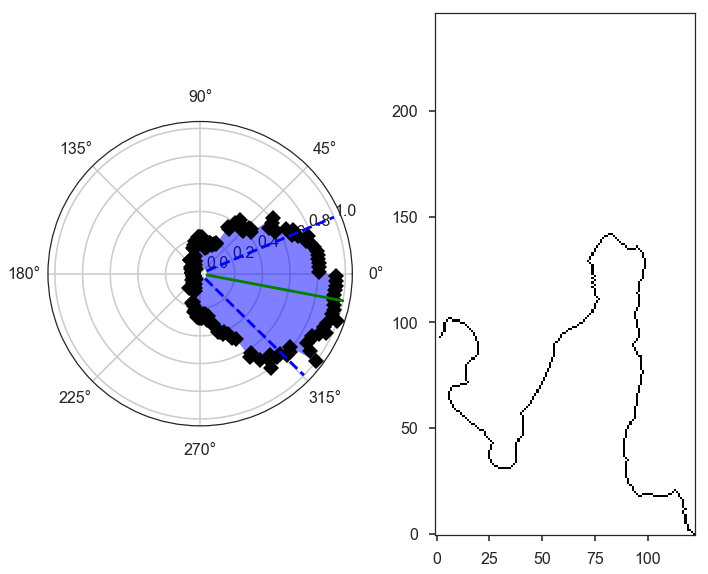

In [156]:
fil.exec_rht()
fil1.plot_rht_distrib()

The RHT distribution is shown for the first skeleton, along with its longest path skeleton. The polar plot shows the distribution as a function of $2\theta$. Since there is no preferred direction, $0$ and $\pi$ are equivalent direction for a filament, and so the distribution is defined over $\theta \in [-\pi/2, \pi/2)$. Plotting the distribution as $2\theta$ makes it easier to visualize with discontinuities. The solid green line shows the mean orientation of the filament, and the curvature region is indicated by the angle between the dashed blue lines.

The RHT distribution is built by measuring the angular distribution in a circular region around each pixel in the skeleton, then accumulating the distribution over all pixels in the skeleton. There are three parameters that affect the distribution:

* `radius` -- the radius of the circular region to use. The default is 10 pixels. The region must be large enough to avoid pixelization (causing spikes at 0, 45, and 90 deg) but small enough to only include the local filament direction.
* `ntheta` -- The number of bins in $\theta$ to calculate the distribution at. Default is 180.
* `background_percentile` -- The accumulation process used to create the distribution will create a constant background level over $\theta$. Peaks in the distribution are better characterized by removing this constant level. The default setting is to subtract the 25th percentile from the distribution.

The RHT returns the orientation and curvature of each filament. The orientation is defined as the circular mean and the curvature is the interquartile region about the mean. See the [documentation](http://fil-finder.readthedocs.io/en/latest/api/fil_finder.FilFinder2D.html#fil_finder.FilFinder2D.exec_rht) for the definitions.

In [157]:
fil.orientation

<Quantity [-0.09372123, -0.4688631 ,  0.04622843,  0.47607807, -0.56841827,
           -0.96319154, -0.57605962, -1.0046175 , -0.02831961, -0.41163082,
           -0.74576315,  0.12105612] rad>

In [158]:
fil.curvature

<Quantity [0.58720166, 0.76920664, 0.50536306, 0.89124894, 0.77025275,
           0.73970447, 0.44143597, 1.07627698, 0.46711777, 0.73452577,
           0.54890669, 0.55313247] rad>

It can be more useful to run this analysis on individual branches to understand the distribution of orientation and curvature across the whole map. This can be performed by enabling `branches=True`:

In [159]:
fil.exec_rht(branches=True, min_branch_length=5 * u.pix)

There is no default plot setting in this case.

An additional parameter is enabled in this mode: `min_branch_lengths`. This avoids running the RHT on very short branches, where pixelization will lead to large spikes towards the axis directions.

The outputs are contained in `FilFinder2D.orientation_branches` and `FilFinder2D.curvature_branches`, which return a list of lists for each filament. These can be visualized as distributions:

Text(0.5,0,'Orientation (rad)')

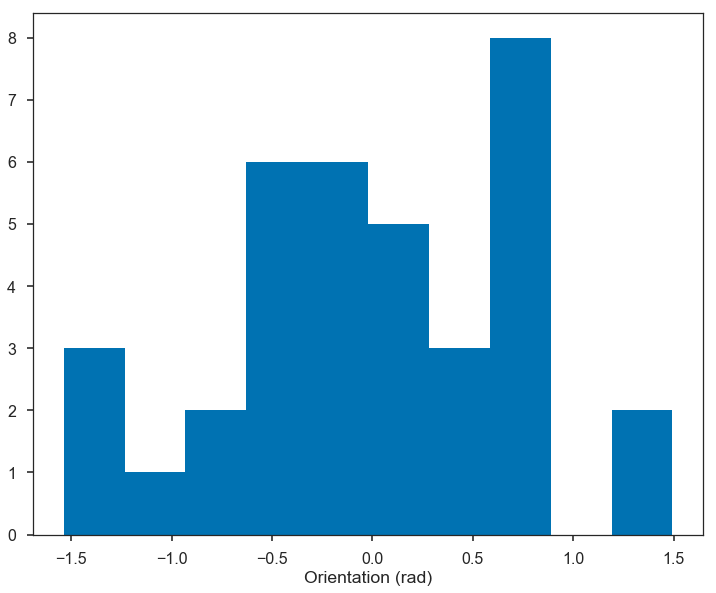

In [160]:
_ = plt.hist(fil.orientation_branches[0].value, bins=10)
plt.xlabel("Orientation (rad)")

Text(0.5,0,'Orientation (rad)')

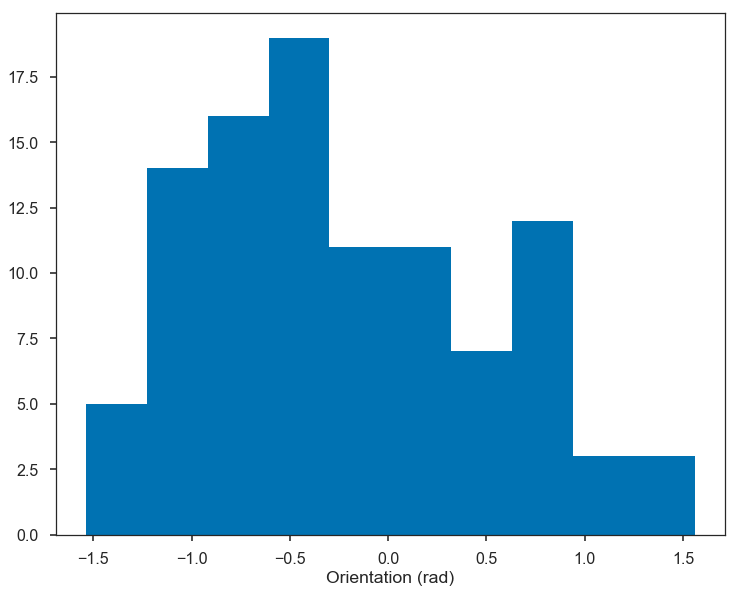

In [161]:
all_orient = np.array([orient.value for fil_orient in fil.orientation_branches for orient in fil_orient])
# Short, excluded branches have NaNs
all_orient = all_orient[np.isfinite(all_orient)]

_ = plt.hist(all_orient, bins=10)
plt.xlabel("Orientation (rad)")

No orientation is strongly preferred in the example data.

Radial Profiles and Widths
-------------------------

`FilFinder2D` finds filament widths by creating radial profiles centered on the skeleton. A simple model can then be fit to the radial profile to find the width.

There are several parameters used to control the creation of the radial profile:

* `max_dist` -- The maximum radial distance to build the radial profile to. Must be given in units of length (pixel, degree, pc, etc...). The default is 10 pixels. In order to not bias the fit, the profile should extend far enough to adequately fit the background level.
* `pad_to_distance` -- FilFinder only includes pixels in the radial profiles that are closest to the filament which avoids double-counting pixels. But if the filaments are closely packed together, this can severely limit the number of points used to make the profile. `pad_to_distance` forces all pixels within the given distance to be included in the profile. Must be given in length units and be less than `max_dist`.
* `use_longest_path` -- Will use the longest path skeleton instead of the full skeleton. Default is False.
* `kwargs` -- These are passed to the [radial_profile](https://github.com/e-koch/FilFinder/blob/master/fil_finder/width.py#L365) function. Please see the documentation in the link for the different options. If an error about empty bins or an array with a shape of 0 is returned, try using `auto_cut=False`.

FilFinder supports 3 simple models for fitting the radial profiles: a Gaussian with a mean fixed to 0 and a constant background, the same Gaussian without a background, and a non-parametric method to estimate Gaussian widths. However, FilFinder uses the [astropy.modeling](http://docs.astropy.org/en/stable/modeling/) package and will accept any 1D astropy model. For example, the [radfil](https://github.com/catherinezucker/radfil) package has an astropy implementation of a Plummer model, which could be used here.

The parameters that control the fitting are:

* `fit_model` -- The model to the profiles to. The defaults are `gaussian_bkg`, `gaussian_nobkg`, and `nonparam`. Otherwise, a 1D astropy model can be given, as discussed above.
* `fitter` -- The fitter to use. See [astropy.modeling.fitter](http://docs.astropy.org/en/stable/modeling/index.html#module-astropy.modeling.fitting). Defaults to a least-squares fitter.
* `try_nonparam` -- If the fit to the model fails, the non-parametric method can be used instead. Default is True.
* `add_width_to_length` -- The fitted FWHM can be added to the lengths (`FilFinder2D.lengths`), assuming that the skeleton's length was shortened by the width in the medial axis transform (`FilFinder2D.medskel`). The width will not be added if the fit was poor or highly unconstrained. Default is True.
* `deconvolve_width` -- Subtract off the beam width when calculating the FWHM width. Default is True.
* `fwhm_function` -- Pass a function that takes the `fit_model` and returns the FWHM and its uncertainty. If None is given, the FWHM is passed assuming a Gaussian profile.
* `chisq_max` -- The critical reduced $\chi^2$ used to determine "bad" fits. The default is 10, and is entirely subjective. This seems to flag most bad fits, but the quality of the fits should always be visually checked.

With the default settings, a Gaussian with a constant background is fit to the profiles:

/home/eric/Dropbox/code_development/filaments/build/lib.linux-x86_64-3.6/fil_finder/filament.py:927: UserWarning: Ignoring adding the width to the length because the fail flag was raised for the fit.
  warnings.warn("Ignoring adding the width to the length because"


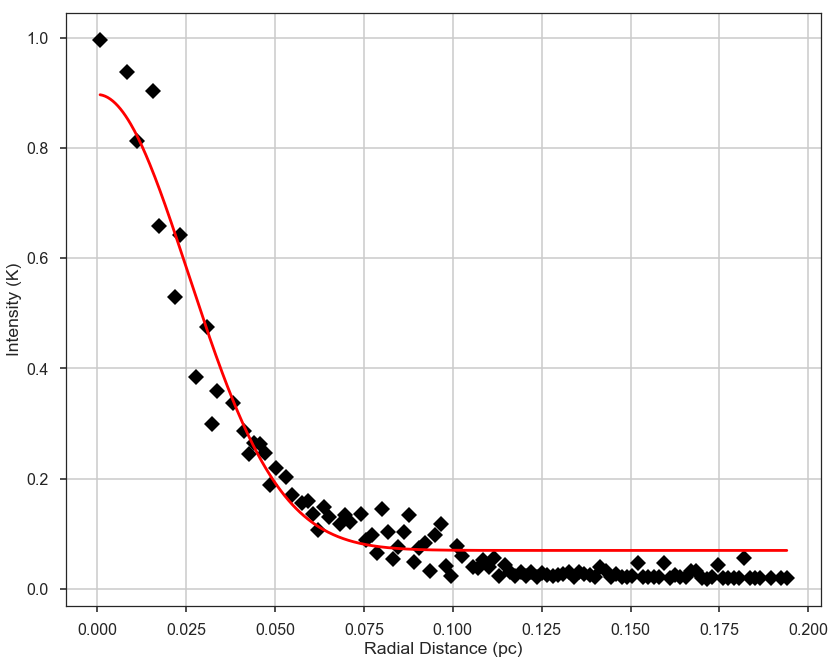

In [162]:
fil.find_widths(max_dist=0.2 * u.pc)
fil1.plot_radial_profile(xunit=u.pc)

The radial profile of the first filament is shown above. The binned radial profile is shown as black diamonds and the fit is shown with the red solid line.

The profile can be plotted with different `xunit`s:

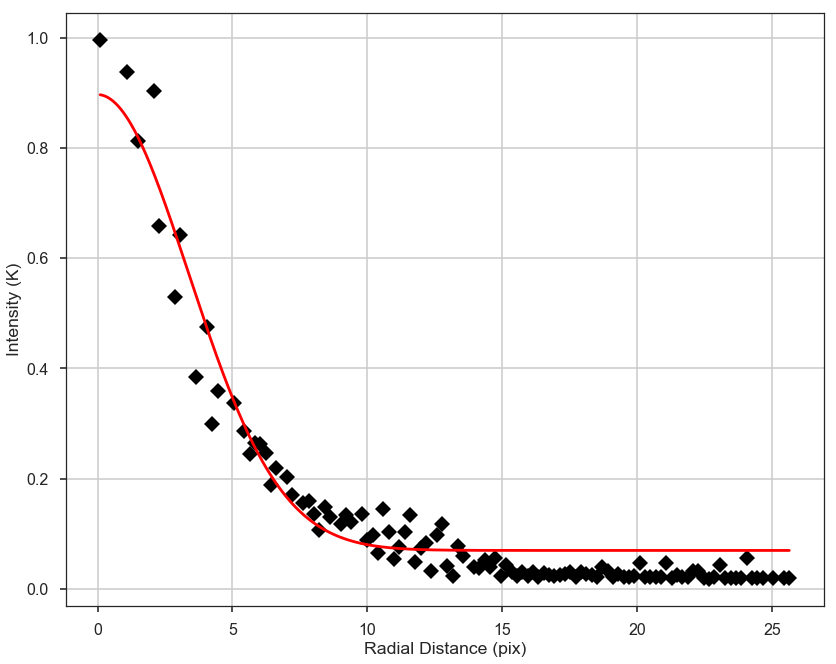

In [163]:
fil1.plot_radial_profile(xunit=u.pix)

Based on the warning above, at least one of the filament profile fits failed. We can look at the list of widths. `FilFinder2D.widths()` returns the FWHMs and their uncertainties:

In [164]:
fil.widths()

(<Quantity [ 6.8908461 ,  4.3148627 ,  7.61875285,  5.73253972,  6.89457072,
             7.01281673, 43.24213164,  5.51177282,  8.63979524,  4.62431374,
             2.61879647,  5.11334422] pix>,
 <Quantity [ 0.21120144,  0.21981508,  0.25891586,  0.34575726,  0.1521915 ,
             0.57087374, 56.06296197,  0.18323136,  0.71417106,  0.42027546,
             0.39571059,  0.23258477] pix>)

These widths can be returned in other units as well:

In [165]:
fil.widths(u.pc)

(<Quantity [0.05211611, 0.03263371, 0.05762134, 0.04335573, 0.05214428,
            0.05303859, 0.32704428, 0.04168605, 0.06534358, 0.03497412,
            0.0198062 , 0.0386727 ] pc>,
 <Quantity [0.00159734, 0.00166248, 0.0019582 , 0.00261499, 0.00115104,
            0.00431757, 0.42400942, 0.0013858 , 0.00540134, 0.00317858,
            0.0029928 , 0.00175906] pc>)

The 6th filament has a much larger width, and its uncertainty is very large. We can look at this radial profile more closely:

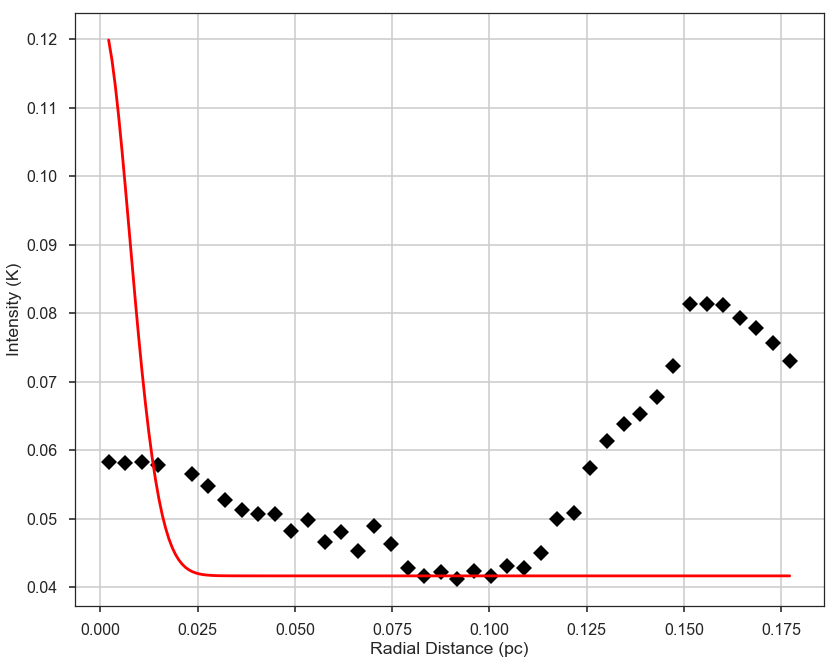

In [166]:
fil.filaments[6].plot_radial_profile(xunit=u.pc)

This is a faint feature near another, and the simple modeling has failed here. This is a case where fine-tuning may lead to a better result for certain filaments. See the `Filament2D` tutorial.

The fit results can be returned as an [astropy table](http://docs.astropy.org/en/stable/table/):

In [167]:
fil.width_fits(xunit=u.pc)

amplitude_0,amplitude_0_err,stddev_0,stddev_0_err,amplitude_1,amplitude_1_err,fwhm,fwhm_err,fail_flag,model_type
,,,,,,pc,pc,,
float64,float64,float64,float64,float64,float64,float64,float64,bool,str12
0.8266318642985881,0.021908564156604842,3.3835577748381396,0.07756760622361797,0.07000301037057191,0.0066838356612052875,0.052116112847711886,0.0015973362521571198,False,gaussian_bkg
1.610889141321533,0.05823998765210095,2.498581466936979,0.0684566283485164,0.10149694602325535,0.011292916525371517,0.03263370969939996,0.0016624820013050273,False,gaussian_bkg
0.8867464296160771,0.031793809834588294,3.6541914982443844,0.09734996214533265,0.1558602055832551,0.00785018512868218,0.05762133955387579,0.001958204832120392,False,gaussian_bkg
0.6715148511637843,0.032901580538658826,2.968437758937908,0.12041344744531615,0.1174774330284996,0.009160806938584936,0.04335573344311829,0.0026149944928117643,False,gaussian_bkg
0.4353429538973092,0.009204276481418352,3.3849258021981505,0.05590272982997455,0.02526366665910463,0.0022355344064575295,0.05214428247972733,0.0011510385041146299,False,gaussian_bkg
0.13653513247619764,0.008853443143977605,3.4284523403458675,0.21058090555591993,0.04690377151911184,0.0038059534077885884,0.053038588139601446,0.004317571408578928,False,gaussian_bkg
0.08139836490154266,0.016841093078255653,0.13947584235216182,0.17929477062975646,0.04166540503501892,0.0183346439152956,0.3270442815271493,0.4240094190495937,True,nonparam
0.21357591588327188,0.005301560204550227,2.89205108873655,0.0629752233735968,0.05620741989680834,0.0013182403481251076,0.04168605274044444,0.0013857959315123815,False,gaussian_bkg


This provides the fit results, the parameter errors, whether or not the fit failed, and the type of model used. The table can then be saved.

Other Filament Properties
------------------------

With the width models, we can define other filament properties, such as the total intensity within the FWHM of the filament:

In [168]:
fil.total_intensity()

<Quantity [7133.15087891, 3538.85058594, 1187.02490234,  853.59997559,
            824.00341797,  350.38427734,   98.00668335,  359.08758545,
            400.62475586, 2129.06005859,   11.55585098, 1204.05969238] K>

If a background was fit in the model, the background level can be subtracted off. The index of the background parameter needs to be given. For the ''gaussian_bkg'', this is `bkg_mod_index=2` and set as the default:

In [169]:
fil.total_intensity(bkg_subtract=True)

<Quantity [6.73875391e+03, 3.37818091e+03, 9.90952759e+02, 7.38237122e+02,
           7.82192078e+02, 2.66426514e+02, 2.17173271e+01, 2.91189026e+02,
           4.04151703e+02, 1.89865674e+03, 6.38404322e+00, 1.11598877e+03] K>

The median brightness along the skeleton is calculated with:

In [170]:
fil.median_brightness()

array([0.995523  , 2.0136652 , 1.088453  , 0.8972937 , 0.503168  ,
       0.1784499 , 0.05824468, 0.27832663, 0.9761157 , 1.8300676 ,
       0.06206793, 3.0347648 ], dtype=float32)

Based on the radial profile models, we can create an image based on the models:

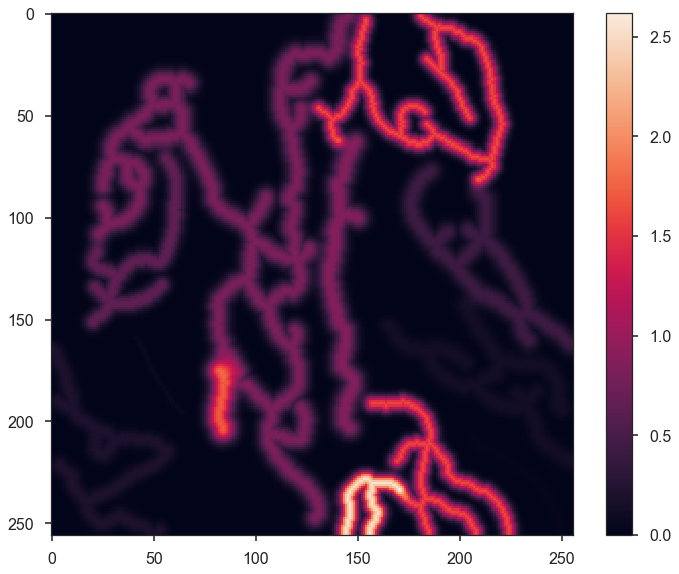

In [171]:
fil_mod = fil.filament_model()
plt.imshow(fil_mod)
plt.colorbar()

By default, the background level is subtracted off, as was used for `fil.total_intensity`. The maximum radius around each skeleton to evaluate the model can also be given with `max_radius`. The default is 3 times the FWHM, which should account for most of the model flux.

This model can be used to estimate the fraction of the total flux contained in the filamentary structure:

In [172]:
fil.covering_fraction()

0.5562639744273953

The same keywords given to `FilFinder2D.filament_model` can be passed here.

The values aligned along the longest path are returned with:

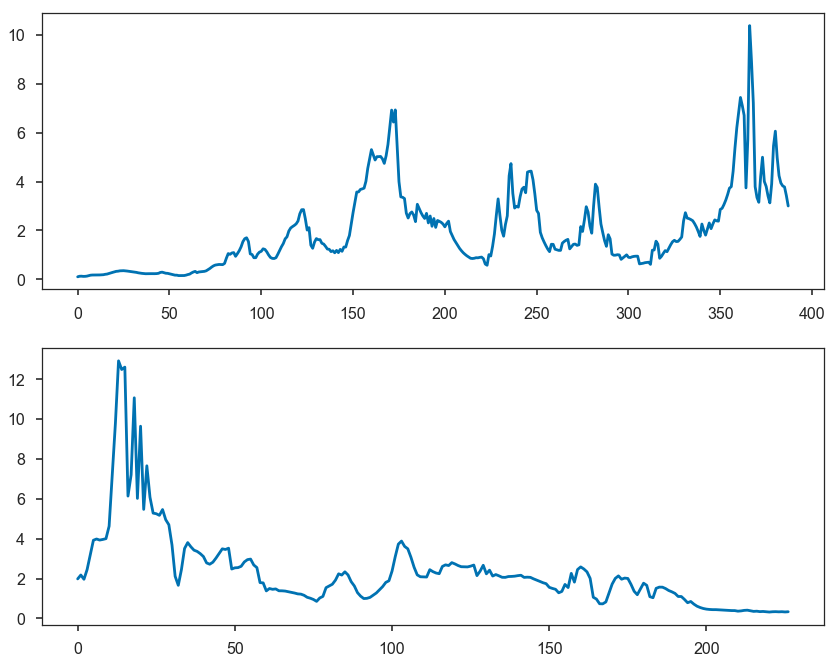

In [173]:
profs = fil.ridge_profiles()
plt.subplot(211)
plt.plot(profs[0])
plt.subplot(212)
plt.plot(profs[1])
plt.tight_layout()

This can be useful for examining the distribution of cores along filaments.

Output Table & Images
------------------------

`FilFinder2D` returns result tables as [astropy tables](http://docs.astropy.org/en/stable/table/). `FilFinder2D.width_fits` is highlighted above.

The width results and additional properties are returned with:

In [174]:
fil.output_table(xunit=u.pc)

lengths,branches,total_intensity,median_brightness,X_posn,Y_posn,amplitude_0,amplitude_0_err,stddev_0,stddev_0_err,amplitude_1,amplitude_1_err,fwhm,fwhm_err,fail_flag,model_type
pc,,K,,pix,pix,,,,,,,pc,pc,,
float64,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,str12
3.4839412361229956,36,7133.15087890625,0.995523,106.0,95.5,0.8266318642985881,0.021908564156604842,3.3835577748381396,0.07756760622361797,0.07000301037057191,0.0066838356612052875,0.052116112847711886,0.0015973362521571198,False,gaussian_bkg
2.080228297847961,15,3538.8505859375,2.0136652,188.0,45.0,1.610889141321533,0.05823998765210095,2.498581466936979,0.0684566283485164,0.10149694602325535,0.011292916525371517,0.03263370969939996,0.0016624820013050273,False,gaussian_bkg
1.2636930050233348,3,1187.02490234375,1.088453,142.0,126.5,0.8867464296160771,0.031793809834588294,3.6541914982443844,0.09734996214533265,0.1558602055832551,0.00785018512868218,0.05762133955387579,0.001958204832120392,False,gaussian_bkg
1.0087060309826756,7,853.5999755859375,0.8972937,43.0,123.0,0.6715148511637843,0.032901580538658826,2.968437758937908,0.12041344744531615,0.1174774330284996,0.009160806938584936,0.04335573344311829,0.0026149944928117643,False,gaussian_bkg
1.2343212651217559,11,824.00341796875,0.503168,213.0,120.5,0.4353429538973092,0.009204276481418352,3.3849258021981505,0.05590272982997455,0.02526366665910463,0.0022355344064575295,0.05214428247972733,0.0011510385041146299,False,gaussian_bkg
1.101360276675763,10,350.38427734375,0.1784499,218.0,178.0,0.13653513247619764,0.008853443143977605,3.4284523403458675,0.21058090555591993,0.04690377151911184,0.0038059534077885884,0.053038588139601446,0.004317571408578928,False,gaussian_bkg
0.3487546458890681,1,98.00668334960938,0.05824468,51.0,177.5,0.08139836490154266,0.016841093078255653,0.13947584235216182,0.17929477062975646,0.04166540503501892,0.0183346439152956,0.3270442815271493,0.4240094190495937,True,nonparam
1.29528624876539,8,359.08758544921875,0.27832663,23.0,216.0,0.21357591588327188,0.005301560204550227,2.89205108873655,0.0629752233735968,0.05620741989680834,0.0013182403481251076,0.04168605274044444,0.0013857959315123815,False,gaussian_bkg


This will include units if attached to the image or radial profile models.

The median positions can also be returned in world coordinates if WCS information was given:

In [175]:
fil.output_table(xunit=u.pc, world_coord=True)

lengths,branches,total_intensity,median_brightness,RA,Dec,amplitude_0,amplitude_0_err,stddev_0,stddev_0_err,amplitude_1,amplitude_1_err,fwhm,fwhm_err,fail_flag,model_type
pc,,K,,deg,deg,,,,,,,pc,pc,,
float64,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,str12
3.4839412361229956,36,7133.15087890625,0.995523,0.05250000000105,-0.0350000000007,0.8266318642985881,0.021908564156604842,3.3835577748381396,0.07756760622361797,0.07000301037057191,0.0066838356612052875,0.052116112847711886,0.0015973362521571198,False,gaussian_bkg
2.080228297847961,15,3538.8505859375,2.0136652,0.1366666666694,0.1016666666687,1.610889141321533,0.05823998765210095,2.498581466936979,0.0684566283485164,0.10149694602325535,0.011292916525371517,0.03263370969939996,0.0016624820013050273,False,gaussian_bkg
1.2636930050233348,3,1187.02490234375,1.088453,0.00083333333335,0.025000000000499997,0.8867464296160771,0.031793809834588294,3.6541914982443844,0.09734996214533265,0.1558602055832551,0.00785018512868218,0.05762133955387579,0.001958204832120392,False,gaussian_bkg
1.0087060309826756,7,853.5999755859375,0.8972937,0.0066666666668,-0.1400000000028,0.6715148511637843,0.032901580538658826,2.968437758937908,0.12041344744531615,0.1174774330284996,0.009160806938584936,0.04335573344311829,0.0026149944928117643,False,gaussian_bkg
1.2343212651217559,11,824.00341796875,0.503168,0.010833333333549999,0.1433333333362,0.4353429538973092,0.009204276481418352,3.3849258021981505,0.05590272982997455,0.02526366665910463,0.0022355344064575295,0.05214428247972733,0.0011510385041146299,False,gaussian_bkg
1.101360276675763,10,350.38427734375,0.1784499,359.9149999999983,0.1516666666697,0.13653513247619764,0.008853443143977605,3.4284523403458675,0.21058090555591993,0.04690377151911184,0.0038059534077885884,0.053038588139601446,0.004317571408578928,False,gaussian_bkg
0.3487546458890681,1,98.00668334960938,0.05824468,359.91583333333165,-0.12666666666919998,0.08139836490154266,0.016841093078255653,0.13947584235216182,0.17929477062975646,0.04166540503501892,0.0183346439152956,0.3270442815271493,0.4240094190495937,True,nonparam
1.29528624876539,8,359.08758544921875,0.27832663,359.8516666666637,-0.17333333333679998,0.21357591588327188,0.005301560204550227,2.89205108873655,0.0629752233735968,0.05620741989680834,0.0013182403481251076,0.04168605274044444,0.0013857959315123815,False,gaussian_bkg


A table for each of the branch properties of the filaments is returned with:

In [176]:
branch_tables = fil.branch_tables()
branch_tables[0]

length,intensity
pix,
float64,float32
62.2842712474619,3.9204443
20.48528137423857,1.1869783
6.242640687119286,0.59490615
13.65685424949238,5.536005
7.0,0.9801212
20.071067811865476,1.3630383
10.65685424949238,1.0734288
14.313708498984761,0.56572586


If the RHT was run on branches, these data can also be added to the branch tables:

In [177]:
branch_tables = fil.branch_tables(include_rht=True)
branch_tables[0]

length,intensity,orientation,curvature
pix,,rad,rad
float64,float32,float64,float64
62.2842712474619,3.9204443,0.6605986359911616,0.9210741882576339
20.48528137423857,1.1869783,0.8013749893786044,0.923494292293757
6.242640687119286,0.59490615,-1.3508316009050338,0.43948899090739646
13.65685424949238,5.536005,1.2752124061527075,0.5512162614209193
7.0,0.9801212,-1.217704747523665e-16,0.320209242394435
20.071067811865476,1.3630383,-0.19871906195057346,0.468575647829656
10.65685424949238,1.0734288,1.4946357727743391,0.3891476232440563
14.313708498984761,0.56572586,0.8255987161778524,0.46475729202323324


These tables can be saved to a format supported by [astropy tables](http://docs.astropy.org/en/stable/table/io.html).

Finally, the mask, skeletons, longest path skeletons, and the filament model can be saved as a FITS file:

In [178]:
fil.save_fits()

OSError: File 'FilFinder_output_image_output.fits' already exists.

This will save the file with prefix given at the beginning. This can be changed by specifying `save_name` here. The keywords for `FilFinder2D.filament_model` can also be specified here.

The regions and stamps around each filament can also be saved with:

In [ ]:
fil.save_stamp_fits()

The same arguments for `FilFinder2D.save_fits` can be given, along with `pad_size` which sets how large of an area around each skeleton is included in the stamp. This will create a FITS file for each filament.